## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [1]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [4]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
850,I described my symptoms to friends and they wo...,1
2524,I'm going to be spending only on essentials. I...,0
1926,The first is my girlfriend of around 9 months....,0
2741,"When you can’t remember the simplest things, b...",1
2608,"I never personally did anything beyond a ""show...",0


In [5]:
df['label'].unique()

array([1, 0], dtype=int64)

In [6]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

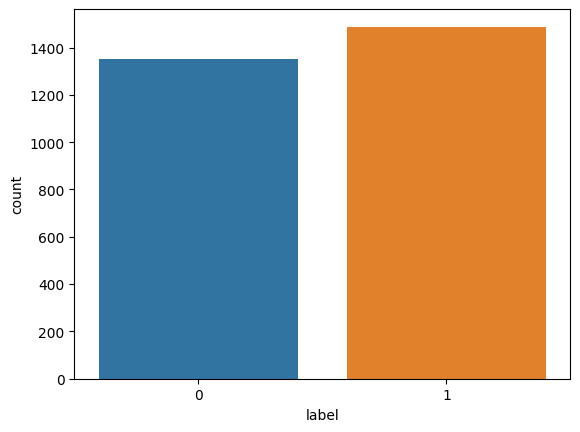

In [7]:
sns.countplot(x='label', data=df)

In [8]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
2459,"realistically, because of geographic lockdown,...",0
2241,the last sticky thread before this one: <url> ...,0
1080,"the connection was 100% real and 100% mutual, ...",0
77,hello guys. this is my first post here. ever s...,1
836,and i’m scared all the time. i get flashbacks ...,1


In [9]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
1573,to me is heartbreaking to know that the most ...,1
811,i'm sharing this in case it helps anyone else ...,0
888,the problem is that i have zero support system...,1
880,edit in the wonderful world of good news the ...,0
1192,she works days a week and usually ends her wo...,0
2490,what if they were met with a broken system the...,0
1687,i dont know what im trying to do by writing th...,0
2692,i just want to get rid of the pent up confused...,1
1173,i began experiencing anxiety attacks around w...,1
596,can't put this under my true account but i'm f...,1


In [10]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 259.2 kB/s eta 0:02:45
     --------------------------------------- 0.1/42.8 MB 409.6 kB/s eta 0:01:45
     --------------------------------------- 0.2/42.8 MB 762.6 kB/s eta 0:00:56
     ---------------------------------------- 0.3/42.8 MB 1.2 MB/s eta 0:00:37
      --------------------------------------- 0.6/42.8 MB 2.1 MB/s eta 0:00:21
      --------------------------------------- 1.0/42.8 MB 2.9 MB/s eta 0:00:15
     - -------------------------------------- 1.8/42.8 MB 5.0 MB/s eta 0:00:09
     -- ------------------------------------- 3.2/42.8 MB 7.5 MB/s eta 0:00:06
     ---- ----------------------------------- 4.6/42.8 MB 10.1 MB/s eta 0:00:04
     ------ --------------------------------- 7.1/42.8 MB 13.7 MB/s eta 0:00:03
     --------- ------------------------------ 9.7/42.8 MB 17.

In [11]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [12]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [13]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
2670,want major broadcastingfilm end coming k debt ...,0
1514,committed mentally therapy knew pay therapist ...,0
1690,it's important needs sound obvious realized ha...,0
1782,dont play know play nbsp weaponizing mental he...,0
1316,currently somewhat reliable car job lined targ...,0
1867,didn't want literally choice didn't kids pray ...,1
2003,waste energy know lived combative relationship...,0
643,borrowed family friends living exhausted i'd s...,1
1893,mom f catered need marriage complains constant...,0
804,i'm fat unattractive unmotivated best figures ...,1


In [14]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [15]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:16<00:00, 165.95it/s]


,text,label
156,good friend day meet treat great love selfish ...,1
1275,figure put guy advice appreciate tldr date mon...,0
1342,year old male lb dog recently homeless washing...,1
2702,week happen time trip decide urgent care point...,0
985,meditation download head space session free de...,0
786,little year high school nearly he s want toron...,0
610,aside kind mess da call tell week abuser put f...,0
1242,know kind place want ask broken bad person sti...,1
2116,move bf fine ' early ' love want spend time mo...,0
1129,reminder use pill box purchase awhile ago take...,0


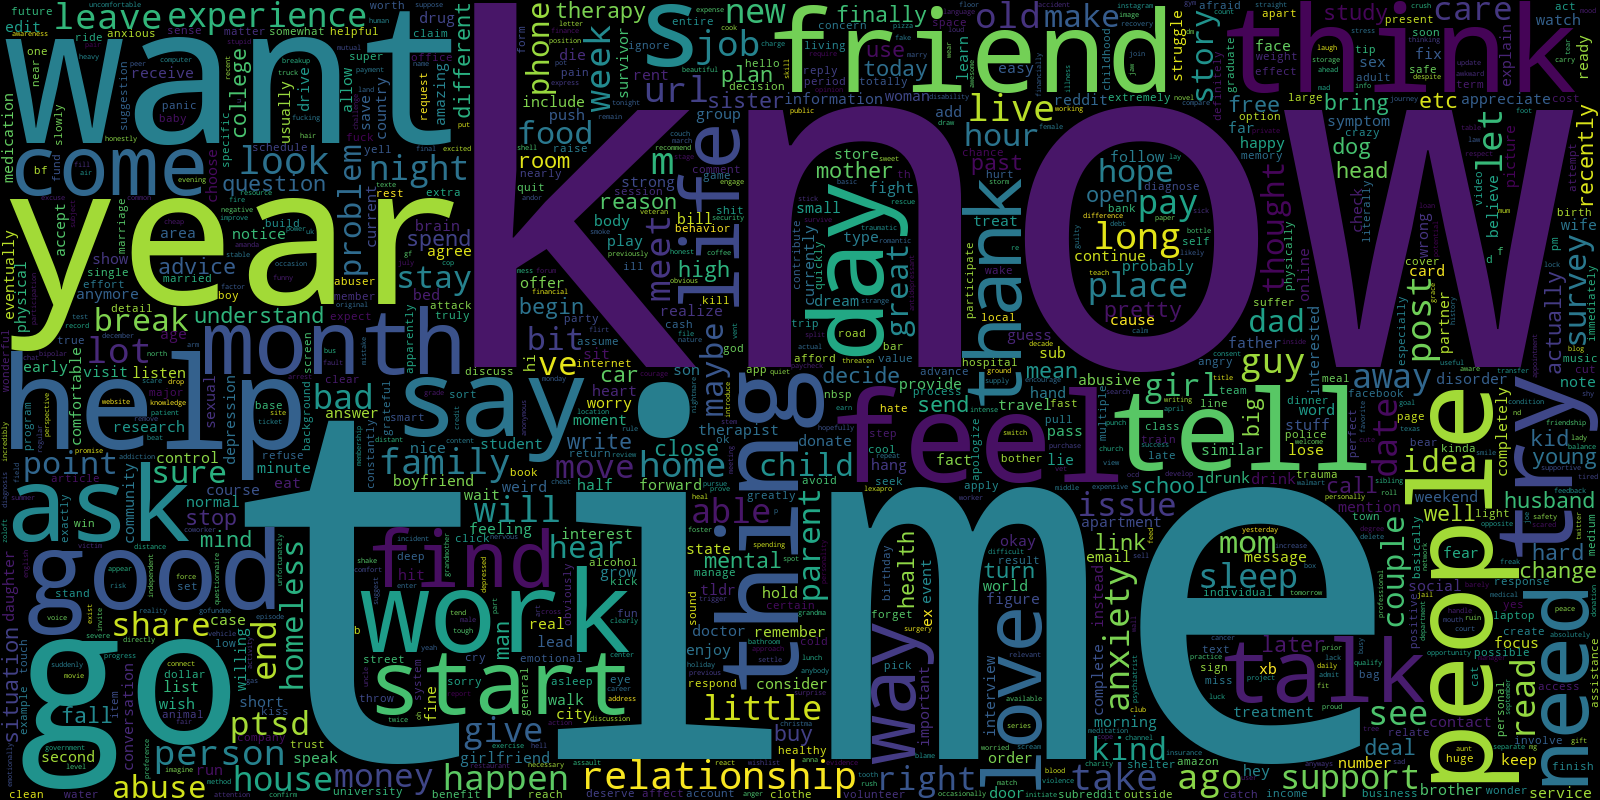

In [16]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

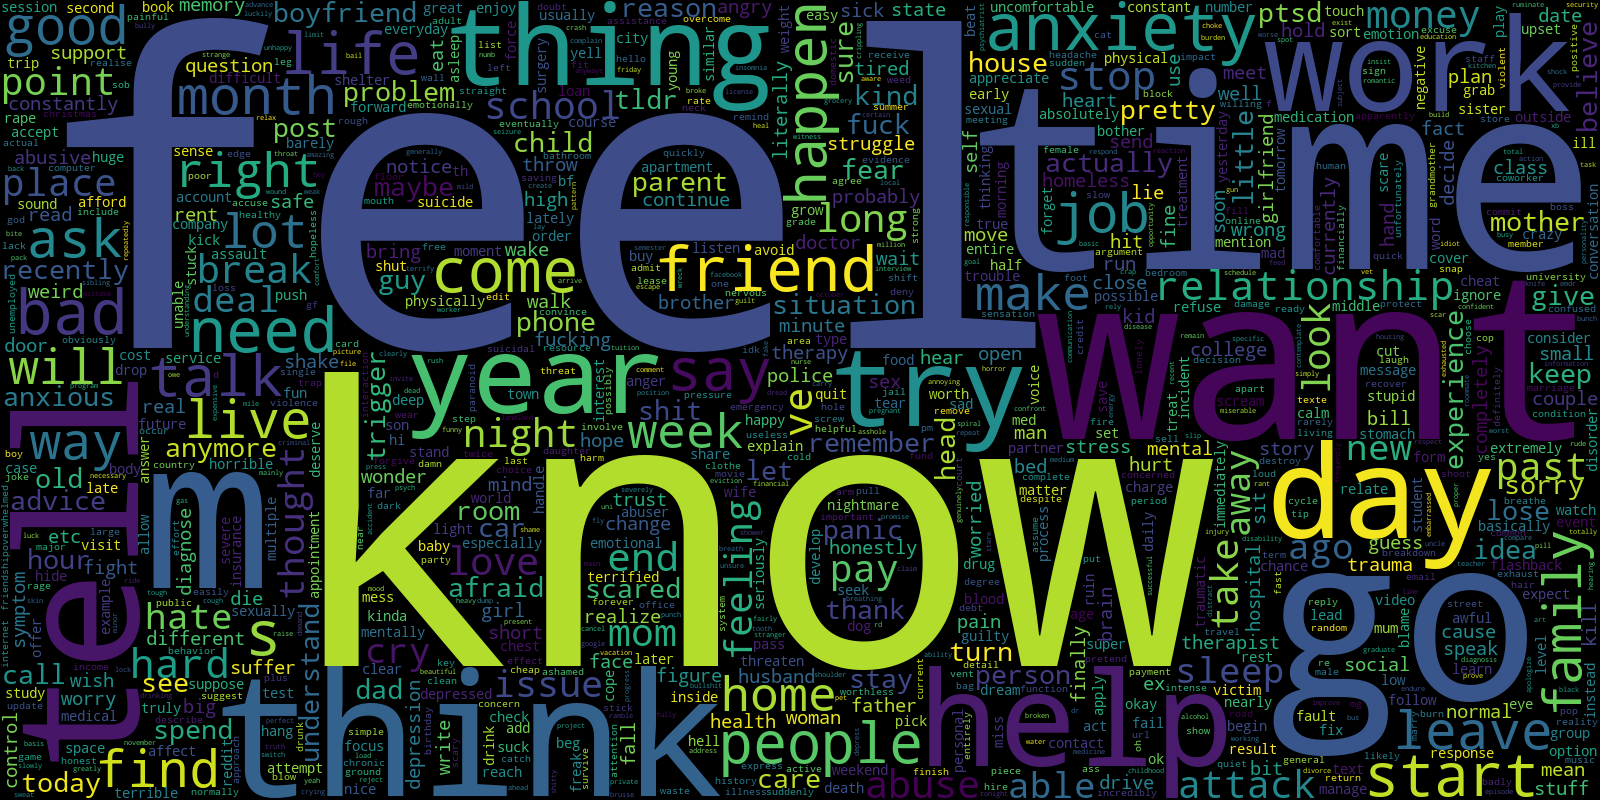

In [17]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów <---
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.1, random_state=42)

In [23]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(seq) for seq in X_train_tokens)

X_train_tokens = pad_sequences(X_train_tokens, maxlen=max_len, padding='post')
X_val_tokens = pad_sequences(X_val_tokens, maxlen=max_len, padding='post')


Podstawienie pre-trained word embeddingów

In [24]:
import gensim.downloader as api

word_vectors = api.load('word2vec-google-news-300')

In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D

#embedding_dim = 300

embedding_matrix = word_vectors.vectors

model_3 = Sequential()
model_3.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_len, trainable=False)) 
model_3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_word2vec = model_3.fit(X_train_tokens, y_train, validation_data=(X_val_tokens, y_val), epochs=5, batch_size=32)


Epoch 1/5
80/80 [==============================] - 34s 336ms/step - loss: 0.6928 - accuracy: 0.5181 - val_loss: 0.6883 - val_accuracy: 0.5603
Epoch 2/5
80/80 [==============================] - 29s 358ms/step - loss: 0.6931 - accuracy: 0.5217 - val_loss: 0.6901 - val_accuracy: 0.5603
Epoch 3/5
80/80 [==============================] - 26s 331ms/step - loss: 0.6925 - accuracy: 0.5217 - val_loss: 0.6890 - val_accuracy: 0.5603
Epoch 4/5
80/80 [==============================] - 29s 363ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.6892 - val_accuracy: 0.5603
Epoch 5/5
80/80 [==============================] - 26s 328ms/step - loss: 0.6921 - accuracy: 0.5217 - val_loss: 0.6894 - val_accuracy: 0.5603


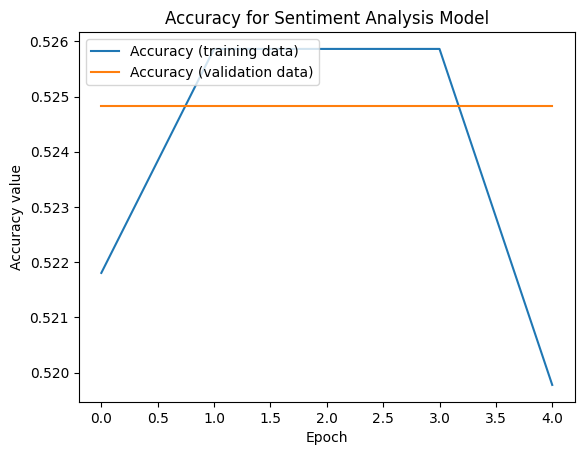

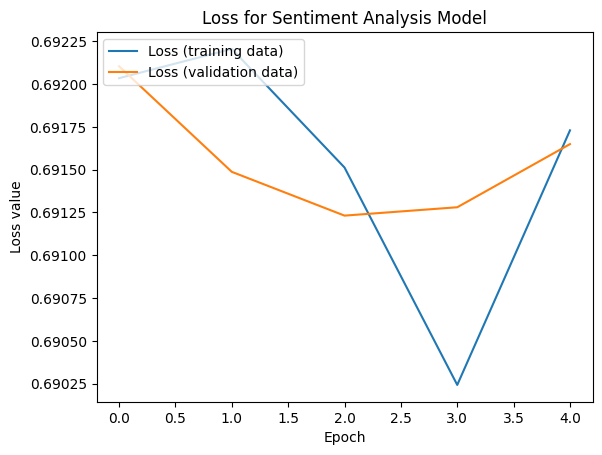

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_word2vec.history['accuracy'], label='Accuracy (training data)')
plt.plot(model_word2vec.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(model_word2vec.history['loss'], label='Loss (training data)')
plt.plot(model_word2vec.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [ ]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=max_len, padding='post')

    return sentence

In [ ]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence"
    else:
        return "All good don't sense ANY STRESS in here "

Podstawienie pre-trained word embeddingów

In [ ]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model_3, sentence)
print(result)

AttributeError: 'RobertaTokenizer' object has no attribute 'texts_to_sequences'